# Midterm Project

The midterm project is designed to let you apply what you have learned so far, and demonstrate that you have mastered it. The submission will be graded on the correctness of the execution of your analysis (50%), the ambitiousness of the problems chosen (30%), and the creativity of your questions and solutions (20%).

Please note that the project is *individual*, and the solutions will be checked for substantial overlap. However, you should feel free to discuss problems and ideas with your class mates, just do not share code.

Your submission should include all outputs and be self-contained, so it can be executed if necessary.


## Submission
The project is due on ***March 27 2020, 23:59 CET***. The time stamp of the email or upload determines the submission time. *Late submissions will NOT be considered, and graded as 0.* To submit, please:

1. rename this file with your student ID
2. copy this file and all additional data into a folder with your student ID
3. zip the entire folder
4. send a copy of the zip file to Tommaso Fornaciari <fornaciari@unibocconi.it>

For large files, you can use `wetransfer`. Please do not use Dropbox links, since they are not time-stamped!

In [1]:
import pandas as pd
import re
import time
import multiprocessing
import numpy as np
import spacy
nlp = spacy.load('en',disable=['parser','ner'])

from gensim.models import Doc2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument
from gensim.corpora import Dictionary

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF,TruncatedSVD
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure
from sklearn.cluster import AgglomerativeClustering

In [2]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## 1. Data and Preprocessing (5 pts)

Pick a data set with **at least 10,000** documents, either from the ones we have used in class, or one that you have found yourself (up to 2 bonus points, depending on size and complexity).
Briefly (max. 100 words!) describe the content and type of the data set (book, reviews, Twitter, ...). 

Preprocess the data and explain (max. 200 words) which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing.

The RAW_recipes.csv dataset cointains more than 230.000 different recipes covering 18 years of user uploads on Food.com. 
The columns are in order:
1. name of the recipe
2. unique id
3. minutes required for the preparation of the recipe
4. contributor_id of the user who uploaded the recipe
5. day of the submission
6. tags related to the recipe
7. nutritional values of the recipe
8. number of steps for the preparation
9. steps
10. description
11. ingredients
12. number of ingredients

In [3]:
df0=pd.read_csv('RAW_recipes.csv')
print('Before pre-processing the dataset has '+str(df0.shape[0])+' entries.\nThe data type of each column is:\n'+str(df0.dtypes)+'\nThe column steps will be the one considered for our analysis and has '+str(len([j for i in df0.steps for j in i.split()]))+' tokens and '+str(len(set([j for i in df0.steps for j in i.split()])))+' types.')

Before pre-processing the dataset has 231637 entries.
The data type of each column is:
name              object
id                 int64
minutes            int64
contributor_id     int64
submitted         object
tags              object
nutrition         object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
dtype: object
The column steps will be the one considered for our analysis and has 23645844 tokens and 108221 types.


The applied pre-processing steps are 4:
1. Importing the database and in the meanwhile converting the columns 'tags' and 'steps' in strings and cleaning them from useless symbols.

2. Creating a column called 'national tags' where I collected the related cusine to the recipe from the column tags; the allowed values are 'european','asian','mexican' and 'african'. I discarded the double origin recipes.

3. Lemmatization of the column steps: I wanted to collect all the nouns and adjectives related to the recipes that can help me to describe the different cusines

4. I wanted to discard all the numeric values because I am not interested in the amounts of the ingredients.

In [26]:
df=pd.read_csv('RAW_recipes.csv',converters={"tags": lambda x: x.strip("[]").replace("'","").split(", "),"steps": lambda x: x.strip("[]").replace("'","")})
df=df[['name','tags','steps']].dropna().reset_index(drop=True)

num = re.compile('[0-9-_]+')
for i in range(df.shape[0]):
    df.loc[i,'national tags']=(", ").join([j for j in df.tags[i] if j in ['european','asian','mexican','african']])
df=df[df['national tags'].isin(['european','asian','mexican','african'])].reset_index(drop=True)

df['steps_lem']=[(" ").join([str(token.lemma_)  for token in nlp(sentence) if token.text!=',' and token.lemma_!='-PRON-' and token.pos_ in {'NOUN','ADJ'}]) for sentence in df.steps]
for i in range(df.shape[0]):
    df.steps[i]=re.sub(num,'',df.steps[i])
df=df.dropna(how='any').reset_index(drop=True)
print('After pre-processing the dataset has '+str(df.shape[0])+' entries.\nThe data type of each column is:\n'+str(df.dtypes)+'\nThe column steps will be the one considered for our analysis and has '+str(len([j for i in df.steps for j in i.split()]))+' tokens and '+str(len(set([j for i in df.steps for j in i.split()])))+' types.\nMoreover I created the column national tags to divide the recipes in 4 diffent groups according to the different cuisines:\n'+str(df['national tags'].unique()))

After pre-processing the dataset has 46461 entries.
The data type of each column is:
name             object
tags             object
steps            object
national tags    object
steps_lem        object
dtype: object
The column steps will be the one considered for our analysis and has 5420429 tokens and 37017 types.
Moreover I created the column national tags to divide the recipes in 4 diffent groups according to the different cuisines:
['mexican' 'asian' 'european' 'african']


In [5]:
df.head()

,name,tags,steps,national tags,steps_lem
0,arriba baked winter squash mexican style,"[60-minutes-or-less, time-to-make, course, mai...","make a choice and proceed with recipe, dependi...",mexican,choice recipe size squash half fourth seed spi...
1,emotional balance spice mixture,"[15-minutes-or-less, time-to-make, course, cui...",mix the spices together and store in an airtig...,asian,spice airtight container small amount butter g...
2,global gourmet taco casserole,"[60-minutes-or-less, time-to-make, course, mai...","heat oven to degrees, brown ground beef and o...",mexican,heat degree brown ground beef onion medium hea...
3,i stole the idea from mirj sesame noodles,"[30-minutes-or-less, time-to-make, course, mai...","in a large pot , cook your angel hair pasta un...",asian,large pot angel hair pasta dente bowl small tu...
4,keep it going german friendship cake,"[weeknight, time-to-make, course, main-ingredi...",mix starter ingredients in a bowl and let stan...,european,starter ingredient bowl room temperature undis...


## 2. Analysis (15 pts)

Describe what question you are investigating with the data (max. 100 words, 2 pts), and apply at least one version of *each* of the following analysis methods to the data set (justify your choices):
1. Create dense word embeddings ***or*** document embeddings and provide some analysis (3 pts) Also use them in at least one of the following:
2. Analysis of important terms (3 pts)
3. Topic modeling: compare matrix factorization with LDA (4 pts). Justify your choice of number of topics!
4. Clustering (3 pts) Justify your choice of number of clusters!

Your analysis needs to be run on **at least 10,000** preprocessed documents!

If appropriate for your probelm, feel free to explore other methods we discussed (NER, parsing, POS, etc.), or algorithms not covered in class (e.g., clustering algorithms, etc.), as long as they do not require additional libraries (up to 2 bonus points).

With the following analysis I will investigate the features of the 4 different type of cuisines; in particular I want to find what are the main foods that characterize each different continent from the others and, considering that this recipes comes from uploads of the last 18 years, if the division acccording to the origin is still a good measure for categorize the foods in different clusters.

# Doc2Vec

The Doc2Vec is runned on the lemmatized steps having as a label the national tags, with the following features:
1. The window is set at 100 words in order to relate the words in the same recipe.
2. The frequency of the words allowed are less than 70% and more than 1% to avoid rare and common ingredients.
3. The dbow_words is set to 1 for visualizing the words related to each cuisine.
4. The dm is set to 0 for applying the PV-DBOW.

In [6]:
corpus = []
for i in range(df.shape[0]):
    label = df['national tags'][i]
    text = str(df['steps_lem'][i])
    corpus.append(TaggedDocument(text.split(), tags=[str(label)]))

d2v_model = Doc2Vec(max_count=0.7,
                    vector_size=300, 
                    window=100,
                    sample=0.000001,
                    min_count=0.01,
                    workers=-1,
                    epochs=500,
                    dm=0, 
                    dbow_words=1,
                    stop_words='english')

d2v_model.build_vocab(corpus)

d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

Some information about each label

In [7]:
d2v_model.docvecs.doctags

{'mexican': Doctag(offset=0, word_count=272397, doc_count=6567),
 'asian': Doctag(offset=1, word_count=547798, doc_count=12949),
 'european': Doctag(offset=2, word_count=1120617, doc_count=24349),
 'african': Doctag(offset=3, word_count=105749, doc_count=2596)}

In [8]:
def cosine_sim(a,b):
    dot = np.dot(a, b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    return dot / (norma * normb)

In [9]:
df_cosine=pd.DataFrame()
for j in ['european','asian','mexican','african']:
    for i in ['european','asian','mexican','african']:
        df_cosine.loc[j,i]=cosine_sim(d2v_model.docvecs[j],d2v_model.docvecs[i])
df_cosine

,european,asian,mexican,african
european,1.000000,-0.034504,-0.028738,0.068939
asian,-0.034504,1.000000,-0.000812,0.022504
mexican,-0.028738,-0.000812,1.000000,0.036437
african,0.068939,0.022504,0.036437,1.000000


There are not positive significative relationships between these cusines, so it seems reasonable continuing this analysis with this division in 4 groups.

# Analysis of important terms through Doc2Vec and TFIDF

I decided to check the most important terms for each cuisine with the Doc2Vec and TFIDF methods by:
1. Finding the 10 most similar words through word-vectors. 
2. Computing th TFIDF scores and filtering for the best 10.

In [10]:
similar_words=[{i:d2v_model.wv.most_similar(positive=[d2v_model.docvecs[i]])} for i in d2v_model.docvecs.doctags.keys()]
df_mostsimilar=pd.DataFrame()
for i in similar_words:
    df_mostsimilar=pd.concat([df_mostsimilar,pd.DataFrame(i)],verify_integrity=False,axis=1)

In [11]:
vectorizer = TfidfVectorizer(analyzer='word', min_df=0.01, max_df=0.7, stop_words='english')
df_tfidf=pd.DataFrame()
for i in ['european','asian','mexican','african']:
    X = vectorizer.fit_transform(df.steps_lem[df['national tags']==i])
    x = pd.DataFrame(data={i: vectorizer.get_feature_names(),
                            'tfidf '+i: X.sum(axis=0).A1}).sort_values('tfidf '+i,ascending=False).reset_index(drop=True)
    df_tfidf=pd.concat([df_tfidf,x],verify_integrity=False,axis=1)
display('df_mostsimilar', 'df_tfidf.head(10)')

,mexican,asian,european,african
0,"(pyrahi, 0.22652049362659454)","(such, 0.21333883702754974)","(meloow, 0.21577665209770203)","(porcelain, 0.22035400569438934)"
1,"(smoother, 0.2204132378101349)","(jack, 0.19747042655944824)","(colby, 0.21525943279266357)","(chenin, 0.21758222579956055)"
2,"(clumpy, 0.21407078206539154)","(steccait, 0.1962887942790985)","(england, 0.2107507586479187)","(car, 0.21672625839710236)"
3,"(spit, 0.21221494674682617)","(pwah, 0.19452397525310516)","(culinary, 0.19610418379306793)","(thern, 0.21358533203601837)"
4,"(longaniza, 0.20643648505210876)","(cucuza, 0.18762356042861938)","(adnd, 0.18653932213783264)","(us, 0.20783796906471252)"
5,"(layer, 0.20525574684143066)","(instant, 0.18747535347938538)","(beaujolai, 0.18460610508918762)","(olde, 0.2002611756324768)"
6,"(nacho, 0.20432093739509583)","(hot, 0.18738460540771484)","(scollop, 0.18294382095336914)","(katakuiko, 0.19492566585540771)"
7,"(zuppa, 0.2042531669139862)","(brimmed, 0.18719588220119476)","(soil, 0.18058636784553528)","(caku, 0.19070324301719666)"
8,"(coilantro, 0.20284339785575867)","(your, 0.18393270671367645)","(darken, 0.17857658863067627)","(tahina, 0.18816599249839783)"
9,"(steaks-, 0.2008865475654602)","(database, 0.1829502284526825)","(compromise, 0.17847371101379395)","(bottom, 0.18793179094791412)"


The TFIDF seems to capture better the most important terms related to each cuisine and offers more stable results compared to the ones provided by the Doc2Vec.

# LDA

The number of topics is justified by the coherence_values applied to LDA.\
The number of topics is the highest value that comes from averaging the UMASS and CV scores.

In [12]:
instances = df.steps_lem.apply(str.split)
dictionary = Dictionary(instances)
dictionary.filter_extremes(no_below=0.001, no_above=0.7)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]
coherence_values = []

dev_size = 20000
eval_size = 5000

for num_topics in range(5,14):
    model = LdaMulticore(corpus=model_corpus[:dev_size], id2word=dictionary, num_topics=num_topics)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances[dev_size:dev_size+eval_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    coherence_values.append((num_topics, umass_score, cv_score))

The best k is: 11


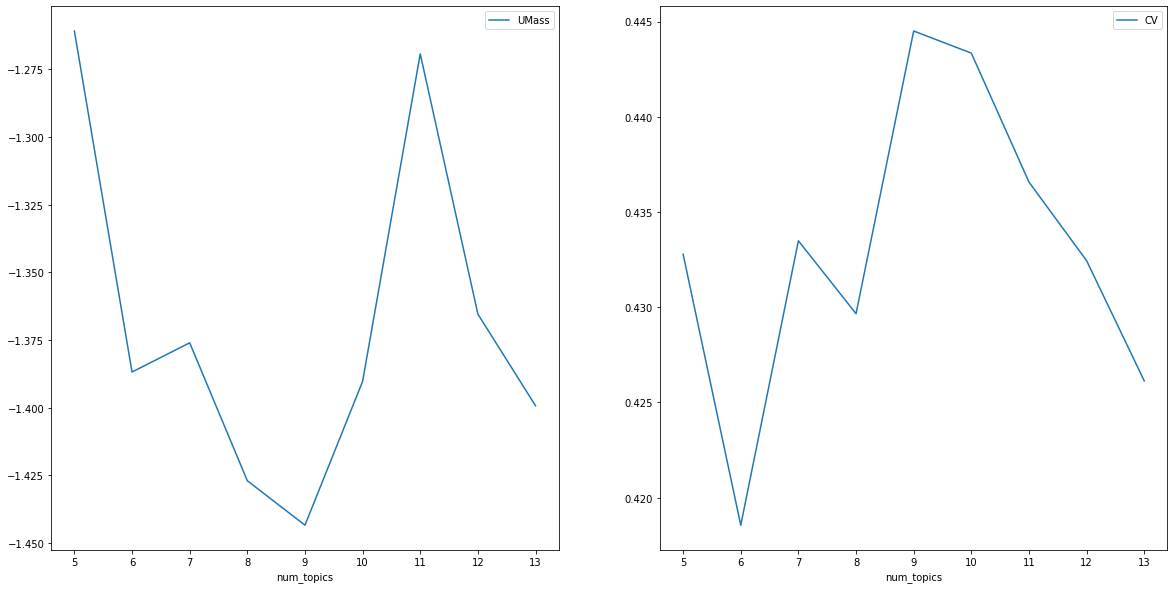

In [13]:
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
scores['best one']=0.5*scores['UMass']/abs(scores['UMass'].mean())+0.5*scores['CV']/scores['CV'].mean()
k=scores.loc[scores['best one'].idxmax(),'num_topics']
print('The best k is:',k)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,14))
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,14));

I chose a small alpha because I wanted to retrieve topics that are document-specific in order to capture the main features of a recipe.

In [14]:
num_topics = k

num_passes = 20
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, 
                     corpus=model_corpus,  
                     id2word=dictionary,
                     workers=min(10, multiprocessing.cpu_count()-1),
                     passes=num_passes,
                     chunksize=chunk_size,
                     alpha=0.1)
    
print("done in {}".format(time.time()-start), flush=True)

4646.1
fitting model
done in 290.34028124809265


In [15]:
topic_corpus = model[model_corpus]
topic_sep = re.compile(r"0\.[0-9]{3}\*")
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    descriptors.append(", ".join(m[:5]).replace('"', ''))
df_lda=pd.DataFrame([i.split(',') for i in descriptors])

# NMF

In [16]:
X = vectorizer.fit_transform(df.steps_lem)
nmf = NMF(n_components=k, init='nndsvd')
W = nmf.fit_transform(X)
H = nmf.components_

In [17]:
terms = vectorizer.get_feature_names()
desc_nmf=[[terms[i] for i in np.argsort(t)[:-6:-1]] for t in H]
df_nmf=pd.DataFrame(sorted(desc_nmf))
display('df_lda', 'df_nmf')

,0,1,2,3,4
0,rice,heat,chicken,sauce,coconut
1,dough,tortilla,cheese,sheet,flour
2,sugar,cake,egg,cream,batter
3,pasta,cheese,tomato,sauce,heat
4,veal,patty,cooker,burger,slow
5,processor,food,container,blender,process
6,potato,tomato,slice,eggplant,pepper
7,ingredient,hour,blender,bowl,salad
8,chicken,breast,pan,heat,skillet
9,marinade,grill,steak,chicken,fish


Both methods seems to provide topics quite reasonable; in the visualization section I showed the relevance of each latent dimension for every continent for both cases.

# Clustering

In this clustering analysis I tested the assumption of dividing the dataset according to the origin of the recipe.\
I chose randomly 10000 of my recipes for applying the agglomerative clustering.\
From the TFIDF and through the SVD I created a 300 dimensions vector for each document, then I applied the agglomerative clustering algorithm with 4 cluster in order to compare this result with my 'naive' clusters through the homogeneity and completeness scores.\
I did not apply k-means step because the results were pretty much as the following.

In [18]:
sample=np.random.choice(len(df.steps_lem),10000,replace=False)
svds = TruncatedSVD(n_components=300)
X2 = svds.fit_transform(vectorizer.fit_transform(df.steps_lem[sample]))
print('The explained variance is :'+str(svds.explained_variance_ratio_.sum()))

agg = AgglomerativeClustering(n_clusters=4)
agg_sample_ids = agg.fit_predict(X2)
centroids = np.array([X2[agg_sample_ids == c].mean(axis=0) for c in range(4)])

h,c,v=homogeneity_completeness_v_measure(df['national tags'][sample],agg_sample_ids)
print('Homogeneity: '+str(h)+'\nCompleteness: '+str(c))

The explained variance is :0.8883488682769836
Homogeneity: 0.018586857305222984
Completeness: 0.02791760307055674


The explained variance of the SVD is quite good (so our matrix explains well the documents), but the homogeneity and completeness scores are very poor.\
This could mean that:
1. The naive country-based clustering is wrong: it is not possible to classify a recipe according to its origin.
2. The number of clusters is not the best one to categorize the recipes.

Both reasons may suggest that, due to globalization, nowadays the recipes from a specified region contain foods that belongs to other cultures and it is no more possible to assert that a specific dish comes from only one origin.\
We check for the optimal value of clusters through the silhouette scores.

In [19]:
silhouettes = []
K = range(3,10)
for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)
    agg_cluster_ids = agg_clustering.fit_predict(X2)
    score = silhouette_score(X2, agg_cluster_ids)
    silhouettes.append(score)
k_opt=K[silhouettes.index(max(silhouettes))]
print('The optimal k value is: ',k_opt)  

The optimal k value is:  9


## 3. Visualization (10 pts)

Provide visualzations for at least 3 of the analyses above. Be creative. Just please do not use word clouds...

# Visualizing the most similar words for each continent using Doc2Vec

In [20]:
def get_terms_vectors(id):
    similar_words=d2v_model.wv.most_similar([d2v_model.docvecs[id]])
    terms=[t for t,v in similar_words]
    return d2v_model[terms],terms

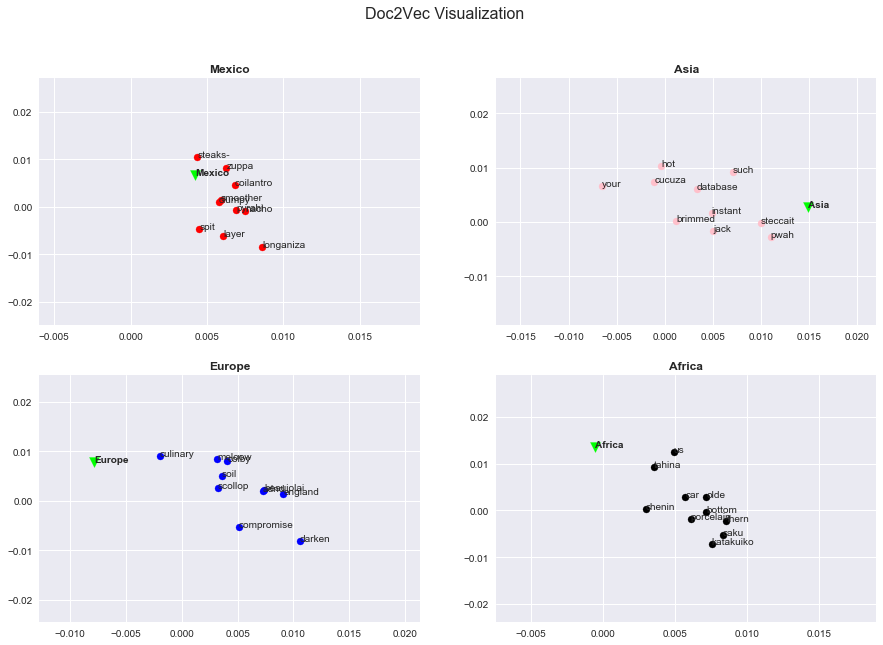

In [21]:
svd = TruncatedSVD(n_components=2)

E,te = svd.fit_transform(get_terms_vectors('european')[0]),get_terms_vectors('european')[1]
M,tm = svd.fit_transform(get_terms_vectors('mexican')[0]),get_terms_vectors('mexican')[1]
AF,taf = svd.fit_transform(get_terms_vectors('african')[0]),get_terms_vectors('african')[1]
AS,tas = svd.fit_transform(get_terms_vectors('asian')[0]),get_terms_vectors('asian')[1]

L=svd.fit_transform([d2v_model.docvecs['mexican'],d2v_model.docvecs['european'],d2v_model.docvecs['asian'],d2v_model.docvecs['african']])

plt.style.use('seaborn')
fig, ax = plt.subplots(2,2, facecolor='w', figsize=(15,10))
fig.suptitle('Doc2Vec Visualization', fontsize=16)

ax[0,0].scatter(M[:,0], M[:,1],marker='o',color='r')
for i in range(10):
    ax[0,0].annotate(tm[i], (M[i,0], M[i,1]))
ax[0,0].scatter(L[0,0], L[0,1],marker='v',color='lime',s=100)
ax[0,0].annotate('Mexico', (L[0,0], L[0,1]),weight='bold')
ax[0,0].set_title('Mexico',weight='bold')

ax[1,0].scatter(E[:,0], E[:,1],marker='o',color='b')
for i in range(10):
    ax[1,0].annotate(te[i], (E[i,0], E[i,1]))
ax[1,0].scatter(L[1,0], L[1,1],marker='v',color='lime',s=100)
ax[1,0].annotate('Europe', (L[1,0], L[1,1]),weight='bold')
ax[1,0].set_title('Europe',weight='bold')

ax[0,1].scatter(AS[:,0], AS[:,1],marker='o',color='pink')
for i in range(10):
    ax[0,1].annotate(tas[i], (AS[i,0], AS[i,1]))
ax[0,1].scatter(L[2,0], L[2,1],marker='v',color='lime',s=100)
ax[0,1].annotate('Asia', (L[2,0], L[2,1]),weight='bold')
ax[0,1].set_title('Asia',weight='bold')

ax[1,1].scatter(AF[:,0], AF[:,1],marker='o',color='k')
for i in range(10):
    ax[1,1].annotate(taf[i], (AF[i,0], AF[i,1]))
ax[1,1].scatter(L[3,0], L[3,1],marker='v',color='lime',s=100)
ax[1,1].annotate('Africa', (L[3,0], L[3,1]),weight='bold')
ax[1,1].set_title('Africa',weight='bold');

# Most important topics per cusine

Visualization of the most relevant topic for each cuisine according to the two methods.

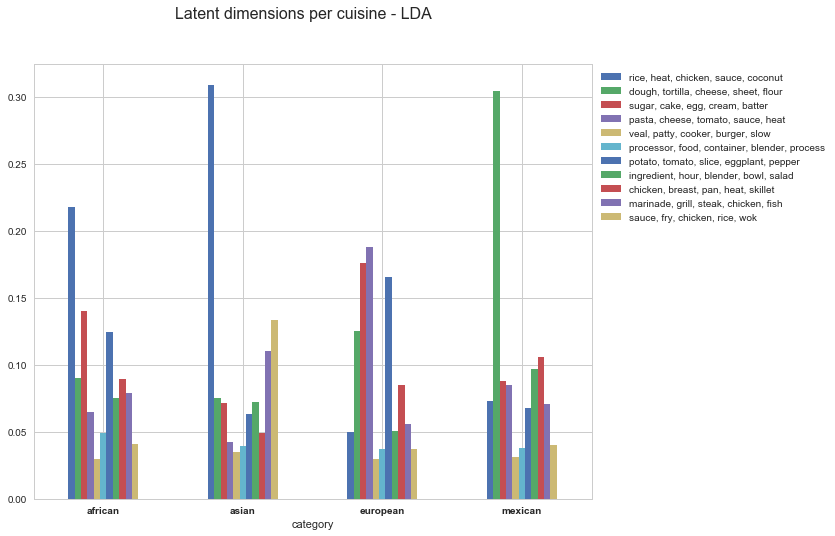

In [22]:
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(topic_corpus))]
topic_distros_lda = pd.DataFrame(data=scores, columns=descriptors)
topic_distros_lda['category'] = df['national tags']

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle('Latent dimensions per cuisine - LDA', fontsize=16)

aggregate_by_category_lda = topic_distros_lda.groupby('category').mean()
aggregate_by_category_lda.plot.bar(ax=ax)
plt.xticks(rotation='horizontal',fontsize='medium',weight='bold')
plt.legend(loc='best',bbox_to_anchor=(1, 1),fontsize='medium');

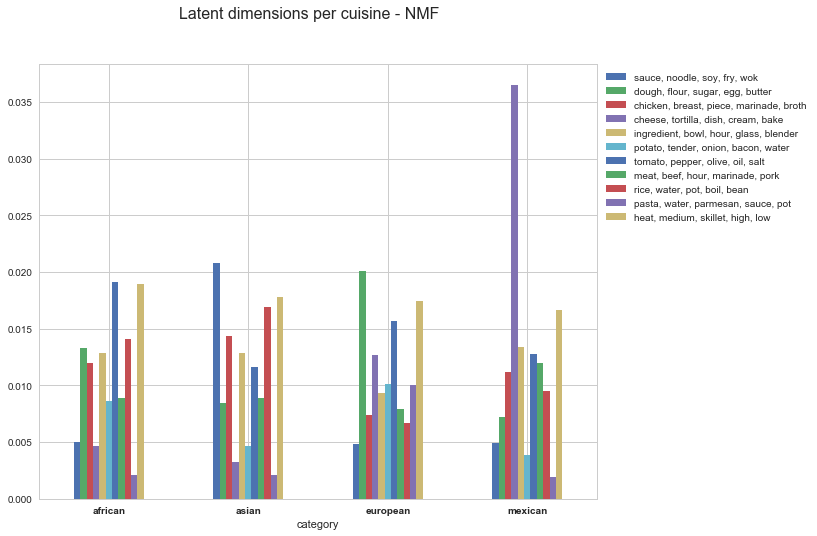

In [23]:
col_names=[(', ').join(i) for i in desc_nmf]
topic_distros_nmf = pd.DataFrame(data=W, columns=col_names)
topic_distros_nmf['category'] = df['national tags']

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle('Latent dimensions per cuisine - NMF', fontsize=16)

aggregate_by_category_nmf = topic_distros_nmf.groupby('category').mean()
aggregate_by_category_nmf.plot.bar(ax=ax)
plt.xticks(rotation='horizontal',fontsize='medium',weight='bold')
plt.legend(loc='best',bbox_to_anchor=(1, 1),fontsize='medium');


# Visualization of the 'naive' country-based clusters and the optimal ones

The graphs show a big difference between the two methods confirming the poorness of the homogeneity and completeness scores and the unattainableness of the country-based clusters.

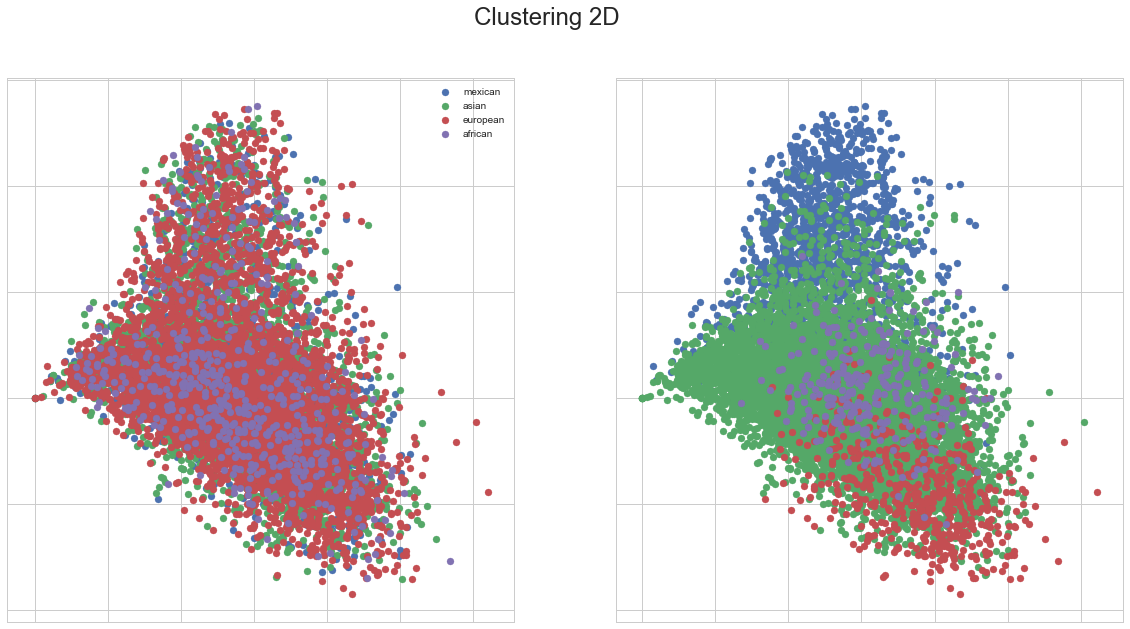

In [24]:
agg = AgglomerativeClustering(n_clusters=4)
agg_sample_ids = agg.fit_predict(X2)

svds = TruncatedSVD(n_components=2)

X3 = svds.fit_transform(X2)
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(20,10))
fig.suptitle('Clustering 2D', fontsize=24)

ax1 = fig.add_subplot(121)

cluster_df=pd.DataFrame(data=X3)
cluster_df=pd.concat([cluster_df,df['national tags']],axis=1).dropna()
for i in df['national tags'].unique():
    temp=cluster_df[cluster_df['national tags']==i]
    ax1.scatter(temp.iloc[:,0],temp.iloc[:,1], label=i)
ax1.axes.xaxis.set_ticklabels([])
ax1.axes.yaxis.set_ticklabels([])
plt.legend(fontsize=10)

ax2 = fig.add_subplot(122)

cluster_df=pd.DataFrame(data=X3)
cluster_df=pd.concat([cluster_df,pd.DataFrame(agg_sample_ids,columns=['label'])],axis=1).dropna()
for i in range(k_opt):
    temp=cluster_df[cluster_df['label']==i]
    ax2.scatter(temp.iloc[:,0],temp.iloc[:,1], label=i)
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])
plt.show()

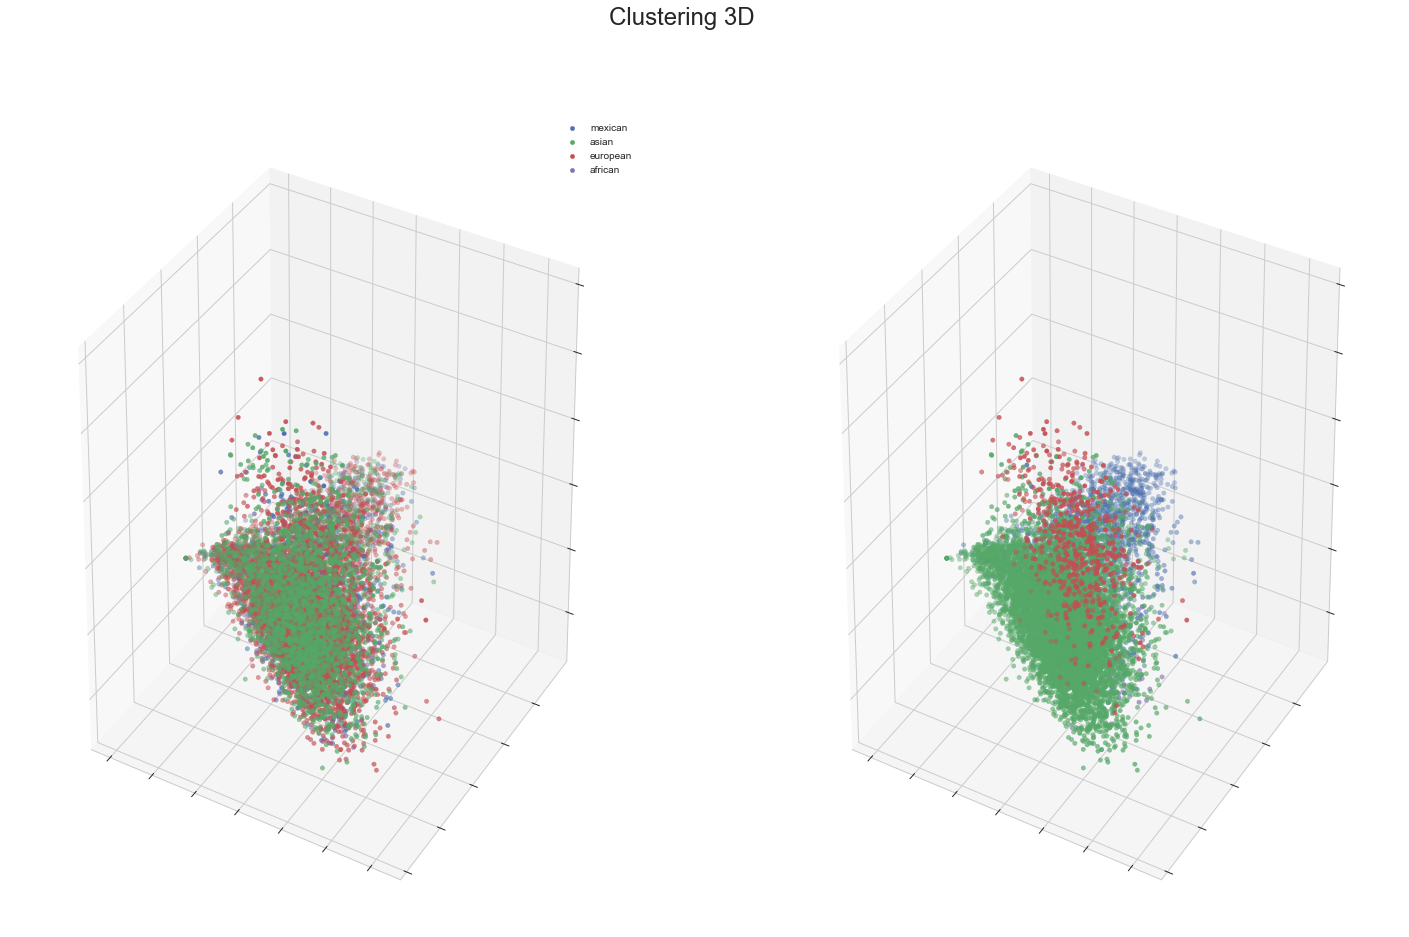

In [25]:
svds = TruncatedSVD(n_components=3)

X4 = svds.fit_transform(X2)
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,15))
fig.suptitle('Clustering 3D', fontsize=24)

ax1 = fig.add_subplot(121,projection='3d')

cluster_df=pd.DataFrame(data=X4)
cluster_df=pd.concat([cluster_df,df['national tags']],axis=1).dropna()
for i in df['national tags'].unique():
    temp=cluster_df[cluster_df['national tags']==i]
    ax1.scatter(temp.iloc[:,0],temp.iloc[:,1],temp.iloc[:,2], label=i)
ax1.axes.xaxis.set_ticklabels([])
ax1.axes.yaxis.set_ticklabels([])
ax1.axes.zaxis.set_ticklabels([])
plt.legend(fontsize=10)

ax2 = fig.add_subplot(122,projection='3d')

cluster_df=pd.DataFrame(data=X4)
cluster_df=pd.concat([cluster_df,pd.DataFrame(agg_sample_ids,columns=['label'])],axis=1).dropna()
for i in range(k_opt):
    temp=cluster_df[cluster_df['label']==i]
    ax2.scatter(temp.iloc[:,0],temp.iloc[:,1],temp.iloc[:,2], label=i)
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])
ax2.axes.zaxis.set_ticklabels([])
plt.show()